In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
# import wandb
# from wandb.keras import WandbCallback
from sklearn.preprocessing import LabelEncoder
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_data_path ="/content/drive/MyDrive/dktc/data/train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [4]:
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화']

class_dict = {}
for idx, class_name in enumerate(CLASS_NAMES):
    class_dict[class_name] = idx

train_data['class'] = train_data['class'].apply(lambda s: class_dict[s])

train_data.head()


,idx,class,conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [5]:
train_data = train_data.drop_duplicates(subset=["class", "conversation"])

In [6]:
corpus = train_data["conversation"]
corpus.head()

0    지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1    길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2    너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3    어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4    저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
Name: conversation, dtype: object

In [7]:
import re

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣ㅏ-ㅣ?.!,]+", " ", sentence)

    sentence = sentence.strip()

    return sentence

In [8]:
corpus = [preprocess_sentence(s) for s in corpus]

In [9]:
HUGGINGFACE_MODEL_PATH = "klue/bert-base"

In [10]:
X_train, X_val, y_train, y_val = train_test_split(corpus, train_data['class'].tolist(), test_size=0.2)

In [11]:
from transformers import BertTokenizerFast

# Load Tokenizer
tokenizer = BertTokenizerFast.from_pretrained(HUGGINGFACE_MODEL_PATH)

# Tokenizing
train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

In [12]:
test_data = pd.read_json("/content/drive/MyDrive/dktc/data/test.json")
test_data = test_data.transpose()
test_data.head()


test_encodings = tokenizer(test_data["text"].tolist(), truncation=True, padding=True)

In [13]:
# # trainset-set
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

# # validation-set
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
))

# # test-set
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings)
))

In [14]:
from transformers import TFBertForSequenceClassification


model = TFBertForSequenceClassification.from_pretrained(HUGGINGFACE_MODEL_PATH, num_labels=4, from_pt=True)

optimizer = tf.keras.optimizers.AdamW(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics = ['accuracy'])

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
history = []
for i in range(10):
    history.append(model.fit(
        train_dataset.shuffle(1000).batch(16),
        validation_data=val_dataset.shuffle(1000).batch(16),
        # callbacks = [callback_earlystop]
    ))

    predicted = model.predict(test_dataset.batch(16))
    predicted = predicted.logits.argmax(axis=-1)

    submission = pd.read_csv("/content/drive/MyDrive/dktc/data/submission.csv")
    submission['class'] = predicted
    submission.to_csv(f"/content/drive/MyDrive/dktc/klue-bert-base-adamw-{i}.csv", index=False)

25/25 [==============================] - 4s 148ms/step


In [24]:
epochs_list = list(range(1, 11))

train_loss = list(map(lambda h: h.history["loss"][0], history))
val_loss = list(map(lambda h: h.history["val_loss"][0], history))
train_accuracy = list(map(lambda h: h.history["accuracy"][0], history))
val_accuracy = list(map(lambda h: h.history["val_accuracy"][0], history))

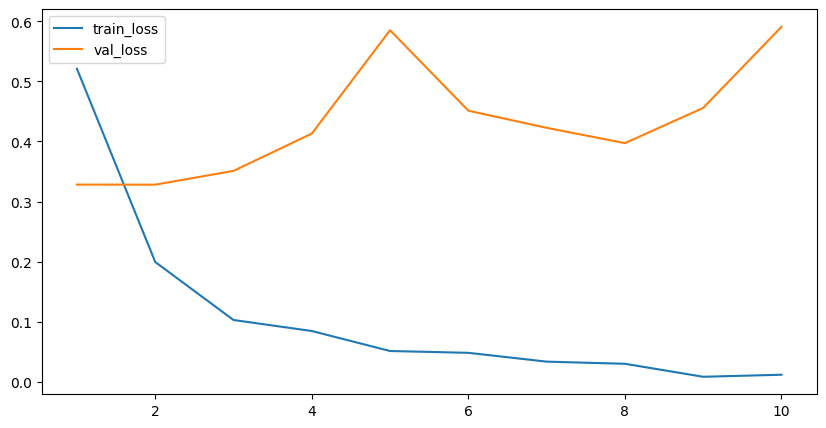

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(epochs_list, train_loss, label="train_loss")
plt.plot(epochs_list, val_loss, label="val_loss")
plt.legend()
plt.show()

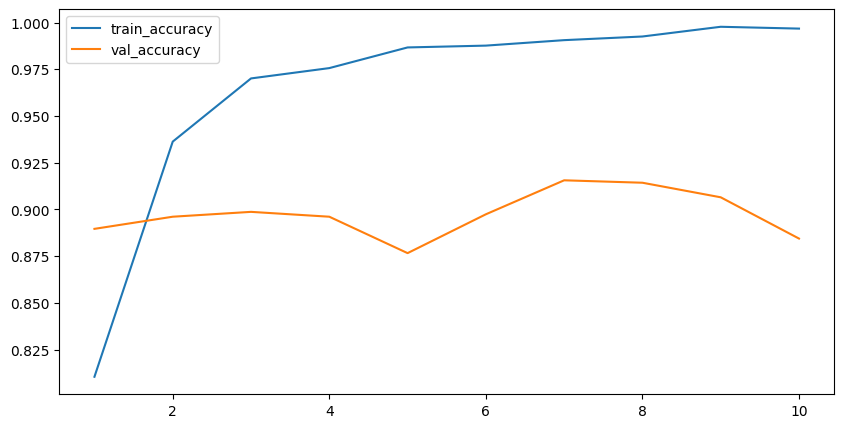

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(epochs_list, train_accuracy, label="train_accuracy")
plt.plot(epochs_list, val_accuracy, label="val_accuracy")
plt.legend()
plt.show()